In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc

import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from face_verification.facenet import basenet
from face_verification.facenet import triplet_net
from face_verification.facenet import triplet_loss
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Dictionary

In [2]:
vgg2_train = pd.read_csv('./images/vgg2_train_path.csv')
vgg2_test = pd.read_csv('./images/vgg2_test_path.csv')

print('Train:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_train['name'].unique()), 
                                                           len(vgg2_train)))
print('Test:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_test['name'].unique()),
                                                          len(vgg2_test)))

vgg2_train.head()

Train:	# person = 8631	 # images = 2113881
Test:	# person =  500	 # images =  116568


,name,path
0,n000002,./images/vgg2_face/train/n000002/0054_01.jpg
1,n000002,./images/vgg2_face/train/n000002/0029_01.jpg
2,n000002,./images/vgg2_face/train/n000002/0202_02.jpg
3,n000002,./images/vgg2_face/train/n000002/0037_01.jpg
4,n000002,./images/vgg2_face/train/n000002/0046_01.jpg


In [3]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [4]:
vgg2_train_df = vgg2_train.groupby('name').apply(path_to_list).reset_index()
vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

vgg2_train_df.head()

,name,count,paths
0,n000002,198,"[./images/vgg2_face/train/n000002/0054_01.jpg,..."
1,n000003,143,"[./images/vgg2_face/train/n000003/0054_01.jpg,..."
2,n000004,334,"[./images/vgg2_face/train/n000004/0054_01.jpg,..."
3,n000005,67,"[./images/vgg2_face/train/n000005/0430_02.jpg,..."
4,n000006,374,"[./images/vgg2_face/train/n000006/0154_01.jpg,..."


# Define Triplet Network

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [6]:
# create the base-cnn model
base_model = basenet(output_shape=128)

# # visualization
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.png')
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.pdf')

# base-model summary
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________

In [7]:
# create the triplet-network model
triplet_model = triplet_net(base_model=base_model, input_shape=(96, 96, 3))

# # visualization
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.png')
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.pdf')

# base-model summary
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          3743280     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Triplet Network Training

In [8]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 900:
        lr *= 1e-1
    elif epoch > 800:
        lr *= 2e-1
    elif epoch > 700:
        lr *= 3e-1
    elif epoch > 600:
        lr *= 4e-1
    elif epoch > 500:
        lr *= 5e-1
    elif epoch > 400:
        lr *= 6e-1
    elif epoch > 300:
        lr *= 7e-1
    elif epoch > 200:
        lr *= 8e-1
    elif epoch > 100:
        lr *= 9e-1
        
    return lr

In [9]:
# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = './models/margin-02-' + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.2))

# define training and test dataset image generator
train_generator = train_triplet_generator(vgg2_train_df, batch_size=128)
test_generator = test_triplet_generator(vgg2_test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 ./models/margin-02-20180802-1957


In [10]:
# fit the model
history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs=1000, 
                                      validation_data=test_generator, validation_steps=50, 
                                      verbose=2, callbacks=callbacks)

base_model.save(path + '/facenet-model.h5')
pickle.dump(history.history, open(path + '/facenet-history.p', 'wb'))
_ = gc.collect()

Epoch 1/1000
 - 124s - loss: 19.8618 - val_loss: 16.0560
Epoch 2/1000
 - 103s - loss: 15.7596 - val_loss: 15.7850
Epoch 3/1000
 - 103s - loss: 13.8527 - val_loss: 11.9734
Epoch 4/1000
 - 101s - loss: 12.5798 - val_loss: 11.1762
Epoch 5/1000
 - 101s - loss: 11.3098 - val_loss: 14.9872
Epoch 6/1000
 - 99s - loss: 11.4714 - val_loss: 9.2701
Epoch 7/1000
 - 99s - loss: 10.9632 - val_loss: 11.3390
Epoch 8/1000
 - 98s - loss: 10.7864 - val_loss: 9.3514
Epoch 9/1000
 - 99s - loss: 10.1882 - val_loss: 9.2702
Epoch 10/1000
 - 98s - loss: 9.6797 - val_loss: 8.9340
Epoch 11/1000
 - 97s - loss: 9.4611 - val_loss: 8.5470
Epoch 12/1000
 - 98s - loss: 9.3595 - val_loss: 11.4402
Epoch 13/1000
 - 98s - loss: 9.0354 - val_loss: 9.0181
Epoch 14/1000
 - 99s - loss: 9.2023 - val_loss: 9.2022
Epoch 15/1000
 - 97s - loss: 8.9433 - val_loss: 8.7046
Epoch 16/1000
 - 97s - loss: 8.6497 - val_loss: 8.2774
Epoch 17/1000
 - 98s - loss: 8.7548 - val_loss: 10.9333
Epoch 18/1000
 - 98s - loss: 8.1278 - val_loss: 7.53

Epoch 150/1000
 - 97s - loss: 4.0235 - val_loss: 3.5749
Epoch 151/1000
 - 97s - loss: 3.9656 - val_loss: 3.8206
Epoch 152/1000
 - 97s - loss: 4.1492 - val_loss: 3.9305
Epoch 153/1000
 - 97s - loss: 4.1517 - val_loss: 3.9745
Epoch 154/1000
 - 97s - loss: 4.2448 - val_loss: 3.8679
Epoch 155/1000
 - 97s - loss: 3.8964 - val_loss: 3.8180
Epoch 156/1000
 - 98s - loss: 4.2640 - val_loss: 3.8559
Epoch 157/1000
 - 97s - loss: 4.1046 - val_loss: 3.6578
Epoch 158/1000
 - 97s - loss: 4.3172 - val_loss: 4.1361
Epoch 159/1000
 - 97s - loss: 4.0517 - val_loss: 3.1221
Epoch 160/1000
 - 98s - loss: 3.8467 - val_loss: 4.2712
Epoch 161/1000
 - 97s - loss: 3.8861 - val_loss: 3.8840
Epoch 162/1000
 - 97s - loss: 4.2617 - val_loss: 5.4441
Epoch 163/1000
 - 97s - loss: 3.9307 - val_loss: 4.2351
Epoch 164/1000
 - 96s - loss: 4.0006 - val_loss: 3.8070
Epoch 165/1000
 - 96s - loss: 4.1587 - val_loss: 4.0726
Epoch 166/1000
 - 96s - loss: 3.9013 - val_loss: 3.9945
Epoch 167/1000
 - 97s - loss: 3.9724 - val_loss:

Epoch 297/1000
 - 96s - loss: 3.1751 - val_loss: 3.0189
Epoch 298/1000
 - 97s - loss: 3.2943 - val_loss: 3.4614
Epoch 299/1000
 - 96s - loss: 3.1072 - val_loss: 2.9129
Epoch 300/1000
 - 97s - loss: 3.1068 - val_loss: 3.2035
Epoch 301/1000
 - 97s - loss: 3.3792 - val_loss: 3.6233
Epoch 302/1000
 - 96s - loss: 3.2269 - val_loss: 2.9287
Epoch 303/1000
 - 97s - loss: 3.0321 - val_loss: 2.6331
Epoch 304/1000
 - 97s - loss: 2.9846 - val_loss: 3.0140
Epoch 305/1000
 - 96s - loss: 2.9683 - val_loss: 2.8838
Epoch 306/1000
 - 97s - loss: 3.2077 - val_loss: 2.9607
Epoch 307/1000
 - 97s - loss: 3.1046 - val_loss: 2.8735
Epoch 308/1000
 - 97s - loss: 2.8119 - val_loss: 3.2389
Epoch 309/1000
 - 97s - loss: 3.2817 - val_loss: 3.2411
Epoch 310/1000
 - 97s - loss: 2.9674 - val_loss: 2.9042
Epoch 311/1000
 - 96s - loss: 3.0164 - val_loss: 3.0615
Epoch 312/1000
 - 97s - loss: 3.1276 - val_loss: 2.9987
Epoch 313/1000
 - 97s - loss: 3.0740 - val_loss: 2.8912
Epoch 314/1000
 - 96s - loss: 3.1756 - val_loss:

Epoch 444/1000
 - 96s - loss: 2.7264 - val_loss: 2.7899
Epoch 445/1000
 - 97s - loss: 2.5117 - val_loss: 2.4468
Epoch 446/1000
 - 97s - loss: 2.7977 - val_loss: 2.7279
Epoch 447/1000
 - 96s - loss: 2.5905 - val_loss: 2.4988
Epoch 448/1000
 - 97s - loss: 2.5486 - val_loss: 2.4787
Epoch 449/1000
 - 96s - loss: 2.6984 - val_loss: 3.0227
Epoch 450/1000
 - 96s - loss: 2.6030 - val_loss: 2.6643
Epoch 451/1000
 - 97s - loss: 2.6061 - val_loss: 2.3306
Epoch 452/1000
 - 96s - loss: 2.5116 - val_loss: 2.5476
Epoch 453/1000
 - 96s - loss: 2.4897 - val_loss: 2.4803
Epoch 454/1000
 - 97s - loss: 2.6602 - val_loss: 2.5918
Epoch 455/1000
 - 97s - loss: 2.7026 - val_loss: 2.7668
Epoch 456/1000
 - 96s - loss: 2.5506 - val_loss: 2.6215
Epoch 457/1000
 - 97s - loss: 2.5672 - val_loss: 2.5946
Epoch 458/1000
 - 97s - loss: 2.5630 - val_loss: 2.7725
Epoch 459/1000
 - 96s - loss: 2.8826 - val_loss: 2.3704
Epoch 460/1000
 - 97s - loss: 2.6885 - val_loss: 2.3733
Epoch 461/1000
 - 96s - loss: 2.4642 - val_loss:

Epoch 591/1000
 - 98s - loss: 2.5005 - val_loss: 2.5768
Epoch 592/1000
 - 97s - loss: 2.2229 - val_loss: 2.3830
Epoch 593/1000
 - 96s - loss: 2.1827 - val_loss: 2.4794
Epoch 594/1000
 - 97s - loss: 2.3863 - val_loss: 2.2561
Epoch 595/1000
 - 97s - loss: 2.4192 - val_loss: 2.2243
Epoch 596/1000
 - 97s - loss: 2.3185 - val_loss: 2.3708
Epoch 597/1000
 - 97s - loss: 2.2682 - val_loss: 2.1815
Epoch 598/1000
 - 97s - loss: 2.3515 - val_loss: 2.5902
Epoch 599/1000
 - 96s - loss: 2.5047 - val_loss: 2.4676
Epoch 600/1000
 - 97s - loss: 2.2255 - val_loss: 2.4701
Epoch 601/1000
 - 97s - loss: 2.4561 - val_loss: 2.4520
Epoch 602/1000
 - 97s - loss: 2.2485 - val_loss: 2.4795
Epoch 603/1000
 - 98s - loss: 2.5005 - val_loss: 2.2453
Epoch 604/1000
 - 96s - loss: 2.2249 - val_loss: 2.1909
Epoch 605/1000
 - 96s - loss: 2.1535 - val_loss: 2.3669
Epoch 606/1000
 - 97s - loss: 2.3190 - val_loss: 2.3948
Epoch 607/1000
 - 97s - loss: 2.4042 - val_loss: 2.2730
Epoch 608/1000
 - 97s - loss: 2.0727 - val_loss:

Epoch 739/1000
 - 97s - loss: 2.1799 - val_loss: 2.0166
Epoch 740/1000
 - 97s - loss: 1.9717 - val_loss: 2.1199
Epoch 741/1000
 - 96s - loss: 1.9890 - val_loss: 1.8678
Epoch 742/1000
 - 97s - loss: 2.0101 - val_loss: 2.2165
Epoch 743/1000
 - 96s - loss: 1.9989 - val_loss: 2.0118
Epoch 744/1000
 - 97s - loss: 2.0794 - val_loss: 2.6013
Epoch 745/1000
 - 96s - loss: 2.1421 - val_loss: 2.0459
Epoch 746/1000
 - 96s - loss: 2.0990 - val_loss: 1.6234
Epoch 747/1000
 - 97s - loss: 2.0284 - val_loss: 2.0411
Epoch 748/1000
 - 97s - loss: 2.1939 - val_loss: 2.2451
Epoch 749/1000
 - 96s - loss: 2.0697 - val_loss: 2.0353
Epoch 750/1000
 - 96s - loss: 1.9243 - val_loss: 1.9645
Epoch 751/1000
 - 97s - loss: 2.1739 - val_loss: 2.0477
Epoch 752/1000
 - 96s - loss: 2.1159 - val_loss: 1.9775
Epoch 753/1000
 - 96s - loss: 2.1970 - val_loss: 1.9564
Epoch 754/1000
 - 97s - loss: 2.1951 - val_loss: 2.1071
Epoch 755/1000
 - 96s - loss: 1.8080 - val_loss: 1.7625
Epoch 756/1000
 - 96s - loss: 2.1790 - val_loss:

Epoch 886/1000
 - 97s - loss: 1.8766 - val_loss: 1.9958
Epoch 887/1000
 - 96s - loss: 1.9698 - val_loss: 1.9037
Epoch 888/1000
 - 96s - loss: 1.7953 - val_loss: 1.8132
Epoch 889/1000
 - 96s - loss: 1.7248 - val_loss: 1.8033
Epoch 890/1000
 - 97s - loss: 2.0756 - val_loss: 2.1140
Epoch 891/1000
 - 96s - loss: 1.8104 - val_loss: 1.9747
Epoch 892/1000
 - 96s - loss: 2.0869 - val_loss: 1.7119
Epoch 893/1000
 - 96s - loss: 1.8414 - val_loss: 1.9998
Epoch 894/1000
 - 97s - loss: 1.7823 - val_loss: 2.4170
Epoch 895/1000
 - 96s - loss: 2.0205 - val_loss: 1.9288
Epoch 896/1000
 - 97s - loss: 2.0142 - val_loss: 1.5733
Epoch 897/1000
 - 97s - loss: 1.7487 - val_loss: 2.0061
Epoch 898/1000
 - 97s - loss: 1.7684 - val_loss: 1.8874
Epoch 899/1000
 - 97s - loss: 1.9091 - val_loss: 2.2918
Epoch 900/1000
 - 97s - loss: 1.8982 - val_loss: 1.6151
Epoch 901/1000
 - 97s - loss: 2.0857 - val_loss: 1.8129
Epoch 902/1000
 - 97s - loss: 1.8986 - val_loss: 2.4114
Epoch 903/1000
 - 97s - loss: 1.7636 - val_loss:

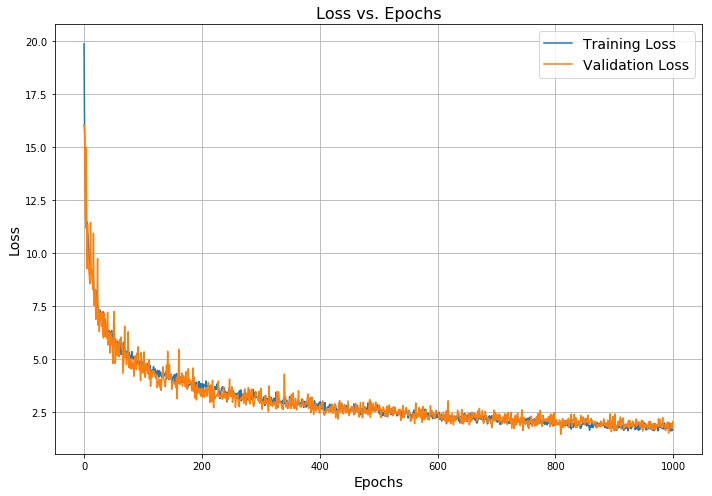

In [11]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()